# Practice: Estacionalidad de Temperaturas en Alemania

### Este ejercicio ha sido propuesto y creado íntegramente por el equipo de AI Saturdays Euskadi (thanks [@MaialenBerrondo](https://www.linkedin.com/in/maialen-berrondo-43197b94/)!)

Un ejemplo típico de estacionalidad y análisis de series temporales es la predicción de la temperatura en un entorno. Por ello, vamos a tomar un caso de estudio de datos de temperaturas de Alemania, y vamos a aplicar una serie de funciones comentadas en la sesión de Time Series Analysis para comprender si existe una estacionalidad real en el caso de las temperaturas de Alemania, y si así se trata, de hacer predicciones de dichas temperaturas.

In [1]:
!pip install pypr

### Nota importante (Añadida desde el equipo de AI Saturdays Euskadi):

Para que te funcione la librería ```ljungbox``` (que permite ejecutar el Q-Test Ljung-Box para encontrar autocorrelación residual), necesitarás hacer el siguiente ajuste en tu instalación de la librería ```pypr```.

[Este enlace contiene la documentación en la que se basa la explicación. Esta explicación aplica a instalaciones hechas en Windows, para sistemas MacOS o Ubuntu habría que validar si el cambio planteado es correcto.](https://gist.github.com/betterxys/1def38e1fcbb7f3b2dab2393bcea52f0)

1. Las librerías que instalas en tu entorno Conda (ya sea mediante el instalador gráfico de Anaconda o mediante comandos pip) se almacenan en una carpeta específica. Navega a la siguiente ruta de tu ordenador: ```{DISCO}\Users\{NOMBRE_USUARIO}\anaconda3\envs\fastai\Lib\site-packages\pypr\stattest```
2. Dentro de esa carpeta verás una carpeta y varios ficheros: ```__pycache__```, ```__init__.py```, ```ljungbox.py``` y ```model.select.py```. Abre el fichero ```__init__.py``` con un editor de texto (Notepad, Notepad++, Sublime Text, vim, nano, etc.).
3. Edita el contenido del fichero para que quede de esta manera:

`
from .ljungbox import *
from .model_select import *
`

¡Y listo! Haz el guardado del contenido editado y ya puedes volver a este Notebook.

In [2]:
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pypr.stattest.ljungbox import * # If there are problems with the library, it just shows the last plot
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.filterwarnings('ignore')

## Load & Clean Data

Como en todo proceso de Análisis de Datos, hay que hacer cierto EDA + Cleaning, para entender lo que tenemos por aquí. Así que carga el fichero CSV y empieza a ver patrones.

Para el propósito de este ejercicio, quédate con aquellos valores del dataset a partir del 1970-01-01 (esa misma fecha inclusive).

In [4]:
# Cargado y lectura de fichero

file_path = 'Germany_temp.csv'

In [5]:
df_germany = pd.read_csv(file_path)

In [6]:
# Ver que hay en el fichero

df_germany.head()

,Date,Avg_Temp
0,01-11-1743,5.468
1,01-12-1743,NaN
2,01-01-1744,NaN
3,01-02-1744,NaN
4,01-03-1744,NaN


In [7]:
# Limpiar todos los datos que hagan falta (eliminar nulos, etc.)

df_germany.set_index(pd.to_datetime(df_germany.Date, format="%d-%m-%Y"), drop=True, inplace=True)
df_germany.drop('Date', axis=1, inplace=True)

In [8]:
df_germany.head()

,Avg_Temp
Date,
1743-11-01,5.468
1743-12-01,NaN
1744-01-01,NaN
1744-02-01,NaN
1744-03-01,NaN


In [9]:
df_germany.shape

(3239, 1)

In [10]:
# Tomar datos a partir de 1970-01-01 (esta fecha inclusive)

df_germany = df_germany.loc['1970-01-01':]

In [11]:
df_germany.shape

(525, 1)

In [12]:
# Comprobar una vez mas que no haya valores nulos ni vacios

count_nan = len(df_germany) - df_germany.count()
count_nan

Avg_Temp    1
dtype: int64

In [13]:
df_germany = df_germany.sort_index()

In [14]:
df_germany.Avg_Temp.fillna(method='pad', inplace=True)

In [15]:
count_nan = len(df_germany) - df_germany.count()
count_nan

Avg_Temp    0
dtype: int64

In [16]:
# Una vez hechas las limpiezas pertinentes, ver como ha quedado nuestro dataset

df_germany.describe()

,Avg_Temp
count,525.000000
mean,8.895307
std,6.695429
min,-6.281000
25%,3.306000
50%,8.417000
75%,15.011000
max,22.343000


In [17]:
df_germany.head(10)

,Avg_Temp
Date,
1970-01-01,-2.721
1970-02-01,-1.331
1970-03-01,1.234
1970-04-01,5.512
1970-05-01,11.665
1970-06-01,17.371
1970-07-01,16.565
1970-08-01,17.229
1970-09-01,13.804


In [18]:
df_germany.tail(10)

,Avg_Temp
Date,
2012-12-01,1.216
2013-01-01,-0.067
2013-02-01,-0.731
2013-03-01,0.394
2013-04-01,8.213
2013-05-01,12.151
2013-06-01,15.927
2013-07-01,19.762
2013-08-01,18.233


## Plot the data & Check stationarity

Y ahora vamos a averiguar si hay cierta estacionalidad implícita en los datos limpiados de temperaturas de Alemania.

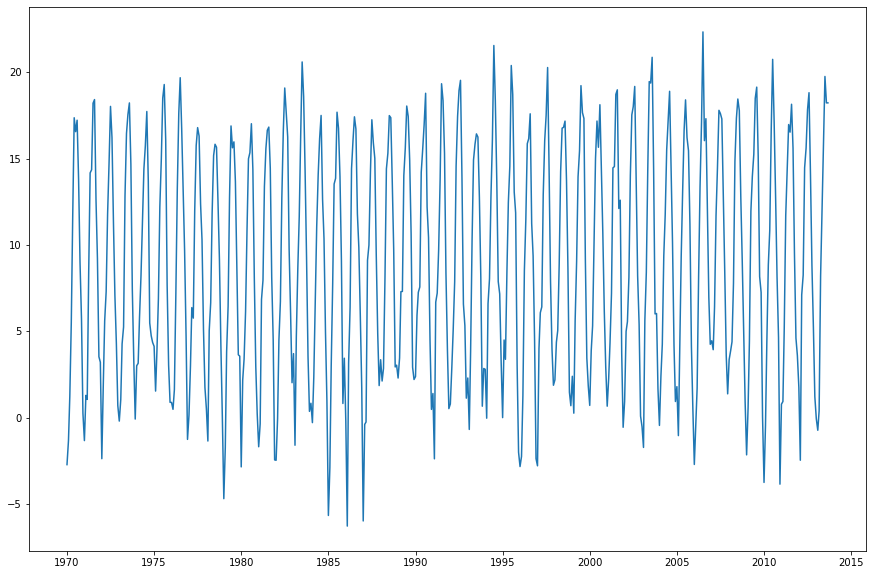

In [22]:
# Hacer un plot de los datos que tenemos

plt.plot(df_germany.Avg_Temp)

In [23]:
# Definir la funcion que compruebe la estacionalidad

def stationarity_check(ts):
    # Determing rolling statistics
    roll_mean = ts.rolling(12).mean()
    # Plot rolling statistics:
    plt.plot(ts, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(ts)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

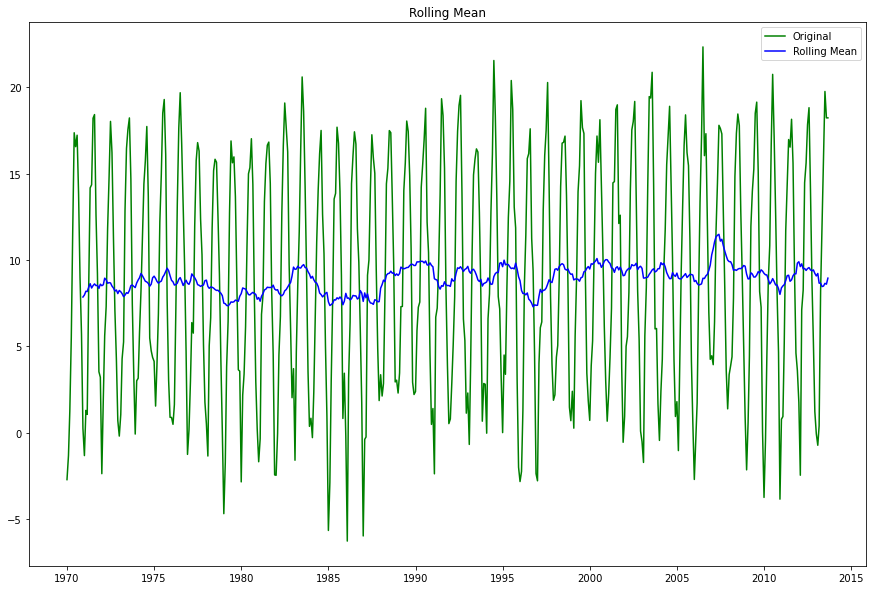

Augmented Dickey-Fuller test:
df_output: 
 Test Statistic                  -4.271198
p-value                          0.000498
#Lags Used                      16.000000
Number of Observations Used    508.000000
dtype: float64
Test Statistic                  -4.271198
p-value                          0.000498
#Lags Used                      16.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64


In [24]:
#Ejecutar dicha funcion

stationarity_check(df_germany.Avg_Temp)

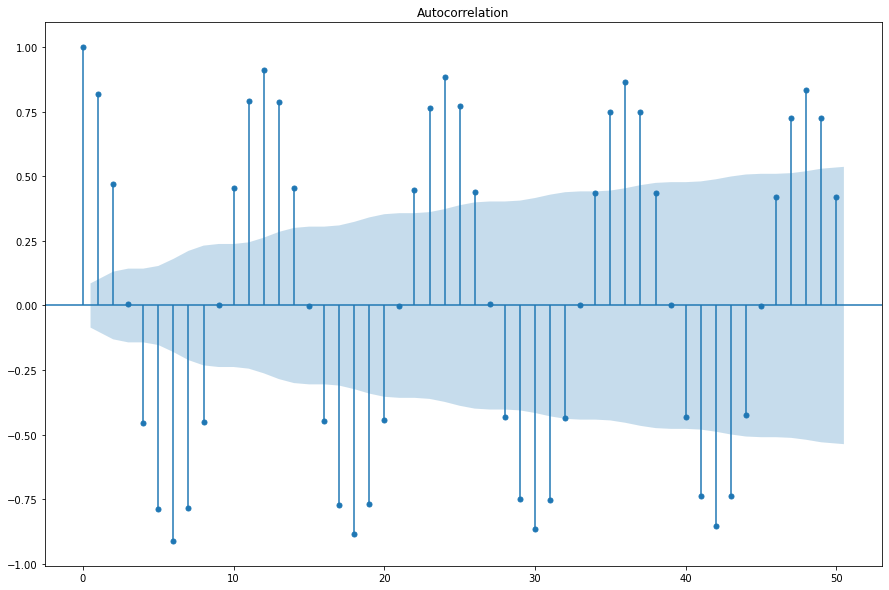

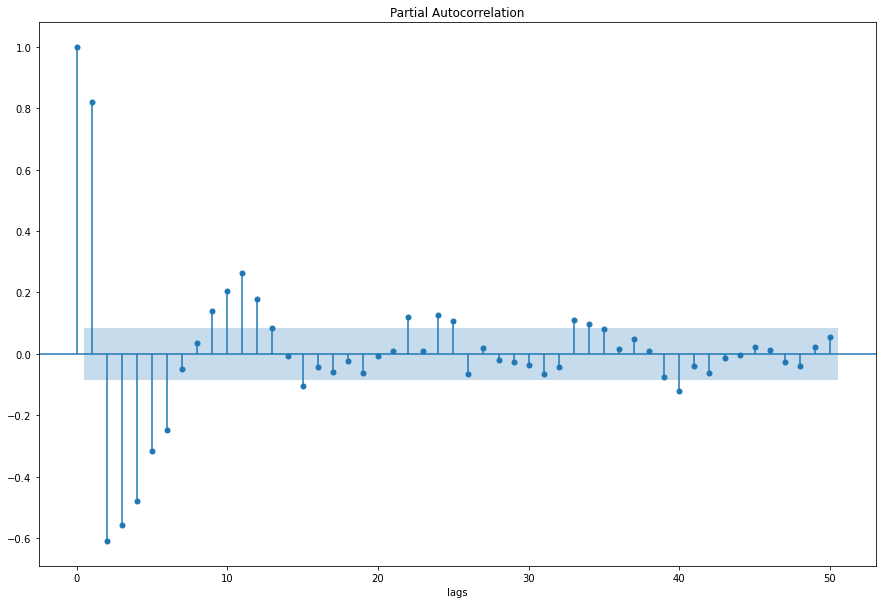

In [25]:
# Hacer un plot de ACF (Autocorrelacion) y PACF (Autocorrelacion Parcial)

plot_acf(df_germany.Avg_Temp, lags=50)
plot_pacf(df_germany.Avg_Temp, lags=50)
plt.xlabel('lags')
plt.show()

## Select the parameters that fit best the models and forecast

Ahora que hemos visto cómo se comportan los valores que tenemos en el dataset, vamos a averiguar qué parámetros seleccionar para ajustar mejor los modelos.

Para ello, en base a estos parámetros establecidos que te dejamos a continuación, haz un cálculo de un modelo ARMA y ARIMA para poder compararlos, y en base al que mejor performance tenga, haz un ajuste y muéstralo en un gráfico.

In [26]:
# Parametros dados

p = q = range(1, 4)
print (p)

range(1, 4)


In [27]:
# Prueba de modelos ARMA

pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(df_germany.Avg_Temp,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARMA(1, 1) - AIC:2794.0131842244573
ARMA(1, 2) - AIC:3051.048038976137
ARMA(1, 3) - AIC:2852.2138707331433
ARMA(2, 2) - AIC:2117.391961853171
ARMA(2, 3) - AIC:2098.505290761074
ARMA(3, 2) - AIC:2097.7144420584186
ARMA(3, 3) - AIC:2118.3917233669845


In [28]:
# Parametros dados

p = q = range(0, 4)
r = range(0,2)

In [29]:
# Prueba de modelos ARIMA

pqr = itertools.product(p, r, q)
for param in pqr:
    try:
        mod = ARIMA(df_germany.Avg_Temp,order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{} - MSE:{}'.format(param, results.aic, np.sum(np.square(results.resid))))
    except:
        continue

ARIMA(0, 0, 0) - AIC:3489.3808038198003 - MSE:23490.274769626667
ARIMA(0, 0, 1) - AIC:3055.9916152796122 - MSE:10290.223914004355
ARIMA(0, 0, 3) - AIC:2737.861080844502 - MSE:5625.684618842306
ARIMA(0, 1, 0) - AIC:2940.7493586725263 - MSE:8333.994289931297
ARIMA(0, 1, 1) - AIC:2854.986454158422 - MSE:7047.41623183339
ARIMA(0, 1, 2) - AIC:2799.207702919936 - MSE:6310.292386327504
ARIMA(0, 1, 3) - AIC:2758.569924809563 - MSE:5815.862683824585
ARIMA(1, 0, 0) - AIC:2902.0000084301937 - MSE:7719.059393660625
ARIMA(1, 0, 1) - AIC:2794.0131842244573 - MSE:6281.6047331435475
ARIMA(1, 0, 2) - AIC:3051.048038976137 - MSE:10117.194865664755
ARIMA(1, 0, 3) - AIC:2852.2138707331433 - MSE:6931.612984814179
ARIMA(1, 1, 0) - AIC:2811.5864258206766 - MSE:6485.812877675356
ARIMA(2, 0, 0) - AIC:2655.3745330345073 - MSE:4849.635215168613
ARIMA(2, 0, 2) - AIC:2117.391961853171 - MSE:1796.2361812060556
ARIMA(2, 0, 3) - AIC:2098.505290761074 - MSE:1731.684211682914
ARIMA(2, 1, 0) - AIC:2804.5176925490205 - M

In [30]:
# Ajuste y prediccion de mejor modelo

model = ARMA(df_germany.Avg_Temp, order=(3,2))  
results_MA = model.fit()

predictions = results_MA.predict('01/01/1970', '12/01/2023')
predictions.head()

1970-01-01     8.875150
1970-02-01    -0.393070
1970-03-01     2.472252
1970-04-01     6.499213
1970-05-01    11.379740
Freq: MS, dtype: float64

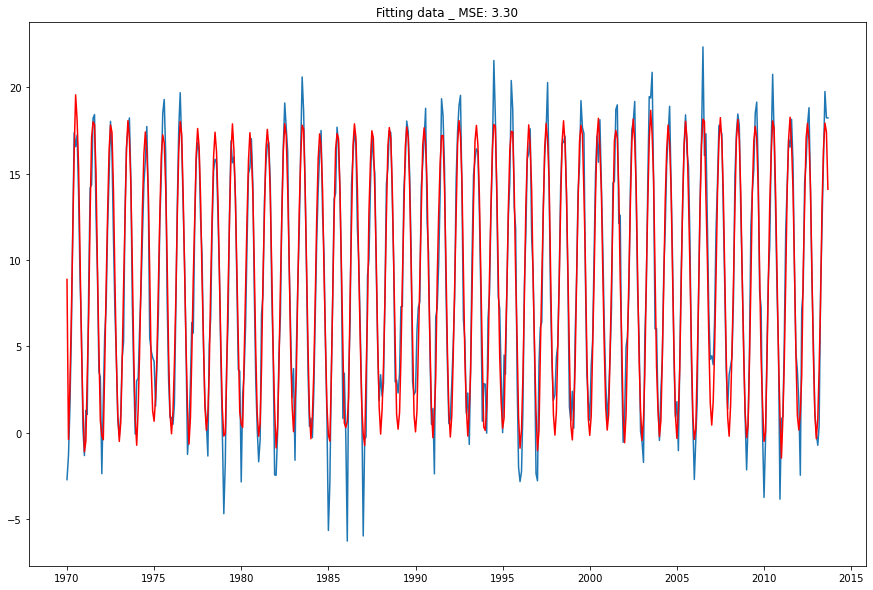

In [31]:
# Plotteo de mejor modelo

plt.plot(df_germany.Avg_Temp)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df_germany.Avg_Temp)**2).mean()))
plt.show()

## More forecasts (SARIMAX)

Finalmente, vamos a hacer una nueva predicción con un modelo distinto, que no sea ARMA o ARIMA, sino de tipo SARIMAX.

In [32]:
#Uso y ajuste de SARIMAX

mod = sm.tsa.statespace.SARIMAX(df_germany.Avg_Temp,
                                order = (2, 0, 3),
                                seasonal_order= (0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

Haz un plot de los diagnósticos del ajuste obtenido en tu modelo ajustado.

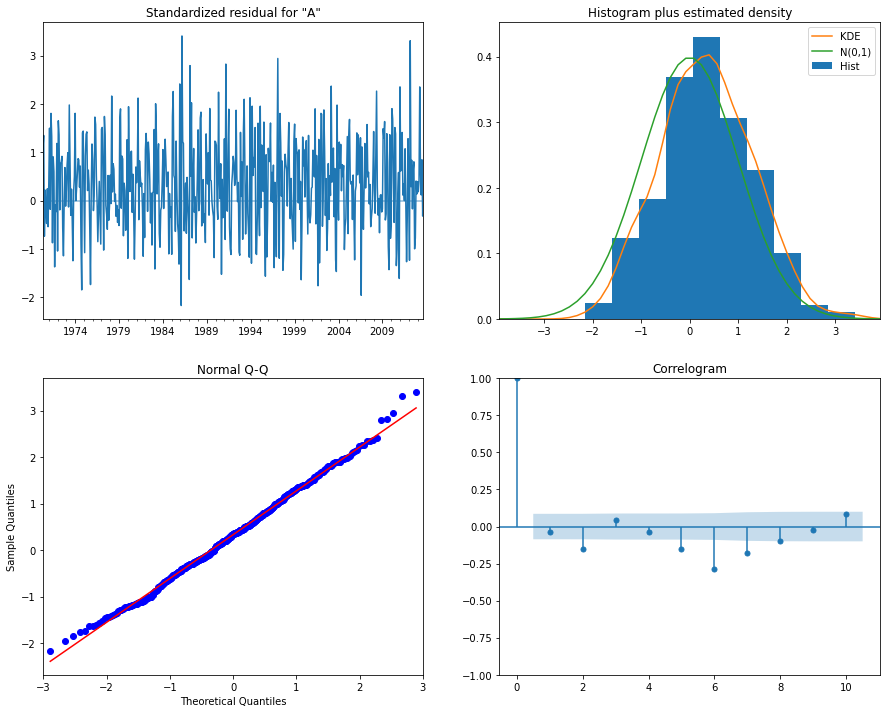

In [33]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Y ahora, utiliza este modelo ajustado para predecir valores, y representa este plotting de manera visual.

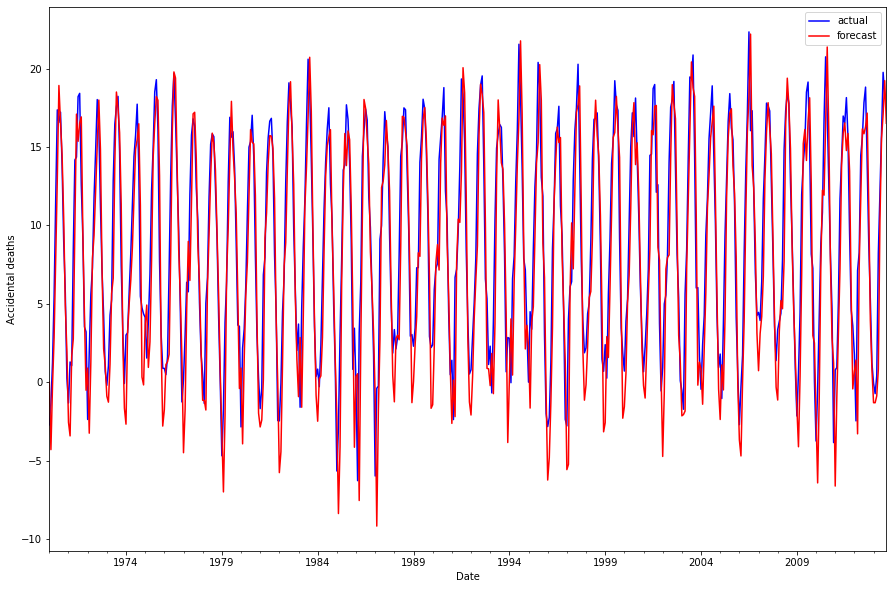

In [34]:
sarimax_predictions = results.predict('01/01/1970', '12/01/2023')
df_germany['forecast'] = sarimax_predictions

df_germany['Avg_Temp'].plot(color='b', label='actual')
df_germany['forecast'].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();

Como se puede observar, el SARIMAX ha capturado mucho mejor las desviaciones de temperaturas, y por tanto permite hacer una predicción más fiel a la realidad que presenta el dataset.